<img src="./image/Title.png">

### 패키지 import 및 bundle 객체 선언

In [1]:
import cv2
import numpy as np
import modi
import time

Running PyMODI (v1.0.1)


In [2]:
bundle = modi.MODI(ai_mode=True)
ai_cam = bundle.ai_cameras[0]
motor = bundle.motors[0]
print('bundle finish')

Initiating can connection...
Start initializing connected MODI modules
Motor (2352) has been connected!
MODI modules are initialized!
MODI AI modules are initialized!
bundle finish


### 선 이미지 출력 함수

In [3]:
def t_display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

### Canny function
##### 윤곽선 추출

In [4]:
# Canny 이미지 처리함수
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

<font size=5em color='red'>확인 코드</font>

In [ ]:
ai_cam.set_window()
ai_cam.set_frame_height(320)
ai_cam.set_frame_weight(240)
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    ai_cam.show(canny_image)

### ROI (Region Of Interest)
##### 영역 설정

In [5]:
def region_of_interest(image):
    mask = np.zeros_like(image)
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    
    bottom_left  = [cols * 0, rows * 0.4]
    top_left     = [cols * 0, rows * 1]
    bottom_right = [cols * 1, rows * 0.4]
    top_right    = [cols * 1, rows * 1]
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

<font size=5em color='red'>확인 코드</font>

In [ ]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    ai_cam.show(cropped_image)

### Hough Lines
##### 직선 추출

In [6]:
def hough_transform(image):
    rho = 7              #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 41       #Only lines that are greater than threshold will be returned.
    minLineLength = 25   #Line segments shorter than that are rejected.
    maxLineGap = 20     #Maximum allowed gap between points on the same line to link them
    
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

<font size=5em color='red'>확인 코드</font>

In [ ]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = hough_transform(cropped_image)
    frame_lines = t_display_lines(frame, lines)
    
    combo_image = cv2.addWeighted(frame, 0.8, frame_lines, 1, 1)
    
    ai_cam.show(combo_image)

### Average Slope
##### 기울기 처리

In [28]:
def average_slope_intercept(lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
        Parameters:
            lines: The output lines from Hough Transform.
    """
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    if 0 <= slope < 0.01:
        slope = 0.01
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    """
    Create full lenght lines from pixel points.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
    """
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.2
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    
    if left_line == None:
        left_line = right_line
    elif right_line == None:
        right_line = left_line
    
#     if lines[0].any() == None:
#         lines[0] = lines[1]
#         print("0 is None!!!!!!!!!!!!")
#     elif lines[1].any() == None:
#         lines[1] = lines[0]
#         print("1 is None!!!!!1")
    return left_line, right_line
    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lines onto the input image.
        Parameters:
            image: The input test image.
            lines: The output lines from Hough Transform.
            color (Default = red): Line color.
            thickness (Default = 12): Line thickness. 
    """
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

<font size=5em color='red'>확인 코드</font>

In [ ]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = hough_transform(cropped_image)
    
    combo_image = draw_lane_lines(frame, lane_lines(frame, lines))
    
    ai_cam.show(combo_image)
    

### Find Vanishing
##### 소실점 추출

In [29]:
# 중심 축과 검출된 선들의 중심축 좌표 출력 함수 
def find_vanishing(image, lines):
#     if lines[0].any() == None:
#         lines[0] = lines[1]
#         print("0 is None!!!!!!!!!!!!")
#     elif lines[1].any() == None:
#         lines[1] = lines[0]
#         print("1 is None!!!!!1")
#     print(lines)
#     if lines.shape != (2,4):
#         lines = [[75, 240,  78,  48], [40, 240,  25,  48]]
    x11, y11, x12, y12 = lines[0]
    cv2.line(image, (x11, y11), (x12, y12), (255, 255, 0), 10)
    x21, y21, x22, y22 = lines[1]
    cv2.line(image, (x21, y21), (x22, y22), (0, 255, 255), 3)
    m1 = (y12 - y11) / (x12 - x11)
    m2 = ((y22 - y21) / (x22 - x21)) -0.001
    cx = int((x11 * m1 - y11 - x21 * m2 + y21) / (m1 - m2))
    center = int(image.shape[1]/2)

    
    cv2.line(image, (cx, 0), (cx, image.shape[0]), (0, 0, 255), 3) 
    cv2.putText(image, str(cx), (cx+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    cv2.line(image, (center, 0), (center, image.shape[0]), (0, 255, 0), 3)
    cv2.putText(image, str(center), (center+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)

    return image, cx, center


<font size=5em color='red'>확인 코드</font>

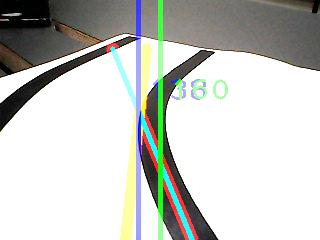

KeyboardInterrupt: 

In [30]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = hough_transform(cropped_image)
    
    lanes = lane_lines(frame, lines)
#     print(lanes[0])
#     print(lanes[1])
    lanes = np.asarray(lanes).reshape(2,-1)
    
    combo_image = draw_lane_lines(frame, lane_lines(frame, lines))
    
    vanishing_line, vanishing, center = find_vanishing(combo_image, lanes)
    final_image = cv2.addWeighted(frame, 0.8, vanishing_line, 1, 1)
    
    ai_cam.show(final_image)

### 모터 & 차량 제어

In [31]:
 
# MODI 모터 제어 함수 
def forward():
    motor.speed= 50, -50
    time.sleep(0.001)
#     motor.speed= 0,0

def left():
    motor.speed= 55, -25
    time.sleep(0.001)
#     motor.speed= 0,0

def right():
    motor.speed = 25, -55
    time.sleep(0.001)
#     motor.speed= 0,0
    
    
# 차량 이동 함수 
# def find_way(vanishing, center):
#     diff = vanishing - center
#     if diff < -15:
#         left()
#         if diff < -40:
#             motor.speed= 50, -25
#             time.sleep(0.01)
#             if diff < -50:
#                 motor.speed= 55, -25
#                 time.sleep(0.01)
#                 if diff < -60:
#                     motor.speed= 60, -25
#                     time.sleep(0.01)
#                     if diff < -120:
#                         motor.speed= 80, -25
#                         time.sleep(0.1)
#     elif diff > 15:
#         right()
#         if diff > 40:
#             motor.speed= 25, -50
#             time.sleep(0.01)
#             if diff > 50:
#                 motor.speed=25, -55
#                 time.sleep(0.01)
#                 if diff > 60:
#                     motor.speed= 25, -60
#                     time.sleep(0.01)
#                     if diff > 120:
#                         motor.speed= 25, -80
#                         time.sleep(0.1)
#     else:
#         forward()

        
# 차량 이동 함수 
def find_way(vanishing, center):
    diff = vanishing - center
    if diff < -15:
        left()
#         if diff < -40:
#             motor.speed= 50, -25
#             time.sleep(0.01)
#             if diff < -50:
#                 motor.speed= 55, -25
#                 time.sleep(0.01)
#                 if diff < -60:
#                     motor.speed= 60, -25
#                     time.sleep(0.01)
#                     if diff < -120:
#                         motor.speed= 80, -25
#                         time.sleep(0.1)
    elif diff > 15:
        right()
#         if diff > 40:
#             motor.speed= 25, -50
#             time.sleep(0.01)
#             if diff > 50:
#                 motor.speed=25, -55
#                 time.sleep(0.01)
#                 if diff > 60:
#                     motor.speed= 25, -60
#                     time.sleep(0.01)
#                     if diff > 120:
#                         motor.speed= 25, -80
#                         time.sleep(0.1)
    else:
        forward()

<font size=5em color='red'>확인 코드</font>

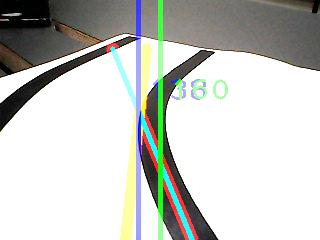

KeyboardInterrupt: 

In [32]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
#     lines = cv2.HoughLinesP(cropped_image, 0.8 , np.pi/180, 15, np.array([]), minLineLength=40, maxLineGap=200)
#     lines = cv2.HoughLinesP(cropped_image, 7 , np.pi/180, 41, np.array([]), minLineLength=25, maxLineGap=20)
    lines = hough_transform(cropped_image)
    if str(type(lines)) == "<class 'NoneType'>":
        continue
    lanes = lane_lines(frame, lines)
    lanes = np.asarray(lanes).reshape(2,-1)
    
    combo_image = draw_lane_lines(frame, lane_lines(frame, lines))
    
    vanishing_line, vanishing, center = find_vanishing(combo_image, lanes)
    final_image = cv2.addWeighted(frame, 0.8, vanishing_line, 1, 1)
    
    ai_cam.show(final_image)
    find_way(vanishing, center)
        

# 확인 문제

### Open CV 이미지 처리

#### 1. 직선을 1개만 추출하려면 어떻게 해야할까요?
#### 2. canny를 적용하지 않고 나머지 코드를 실행하면 어떤 결과가 나올까요?
#### 3. grayscale을 적용하지 않고 나머지 코드를 실행하면 어떤 결과가 나올까요?